In [243]:
import numpy as np
import time
from abc import ABC, abstractmethod
from typing import List, Optional
import matplotlib.pyplot as plt

## Utils

In [35]:
def int2bin(x: int, size: int):
    return bin(x)[2:].zfill(size)


def float2int(x: float, n: int):
    return int(x * pow(2, n))

## Bit Stream

In [4]:
class BitStream:
    def __init__(self):
        self.stream = 0  # The content of the stream
        self.size = 0  # The current size of the stream

    def add_bits(self, bits: int, bit_count: int):
        """Add bits to the stream.

        Args:
            bits (int): The integer containing the bits to add (e.g.  0b101).
            bit_count (int): The number of bits to add from the 'bits' integer (e.g. 3).
        """
        self.stream = (self.stream << bit_count) | (bits & ((1 << bit_count) - 1))
        self.size += bit_count

    def pop_bits(self, bit_count: int) -> int:
        """Read qnd remove a certain number of bits from the stream.

        Args:
            bit_count (int): The number of bits to read.

        Returns:
            int: The extracted bits as an integer.
        """
        if bit_count > self.size:
            raise ValueError("Not enough bits in the stream to read.")

        # Extract the bits from the most significant part of the stream
        result = self.stream >> (self.size - bit_count)
        # Remove the bits we just read
        self.stream &= (1 << (self.size - bit_count)) - 1
        self.size -= bit_count

        return result

    def read(self):
        """Read the content of the stream as a binary int

        Returns:
            int: the content of the stream as an integer
        """
        return self.stream

    def __str__(self) -> str:
        """Return the bit stream as a binary string for easy visualization."""
        return bin(self.stream)[2:].zfill(self.size)

In [5]:
bitStream = BitStream()
bitStream.add_bits(0b00010, 5)
print(bin(bitStream.stream)[2:].zfill(5))
bitStream.pop_bits(2)
print(bin(bitStream.stream)[2:].zfill(2))

00010
10


## LFSR

In [36]:
class LFSR:
    def __init__(self, seed: int, taps: list[int], size: int):
        self.seed = seed
        self.taps = taps
        self.size = size
        self.register = seed
        self.output_bit = 0

    def step(self):
        feedback = 0
        for tap in self.taps:
            feedback ^= (self.register >> tap) & 1

        # Shift the register to the right and set the most significant bit to the feedback bit
        self.register = (self.register >> 1) | (feedback << (self.size - 1))
        self.output_bit = self.register & 1
        return self.register

## Abstract Module

In [37]:
class SCModule(ABC):
    def __init__(self, input_modules: Optional[List["SCModule"]] = None, **kwargs):
        self.input_modules = input_modules
        if self.input_modules is not None:
            self.input_number = len(input_modules)
            self.input_bits = [0] * self.input_number
        self.output_bit = 0

    def step(self):
        if self.input_modules is not None:
            for i in range(self.input_number):
                self.input_bits[i] = self.input_modules[i].output_bit

# B2S and S2B convertor

In [203]:
class Binary2StochasticUnipolar(SCModule):
    def __init__(self, lfsr_seed: int, lfsr_taps: int, size: int, name: str):
        super().__init__()
        self.lfsr = LFSR(seed=lfsr_seed, taps=lfsr_taps, size=size)
        self.n = size
        self.name = name

    def set_input_value(self, input_value: float):
        assert 0 <= input_value <= 1, "Input value must be in [0,1]"
        self.input_value = input_value
        self.input_value_unipolar = pow(2, self.n) * input_value

    def step(self):
        # print(f"B2S called {self.name} has been stepped")
        super().step()
        rng = self.lfsr.step()
        self.output_bit = int(self.input_value_unipolar > rng)

In [207]:
class Binary2StochasticBipolar(SCModule):
    def __init__(self, lfsr_seed: int, lfsr_taps: int, size: int):
        super().__init__()
        self.lfsr = LFSR(seed=lfsr_seed, taps=lfsr_taps, size=size)
        self.n = size

    def set_input_value(self, input_value: float):
        assert -1 <= input_value <= 1, "Input value must be in [0,1]"
        self.input_value_bipolar = pow(2, self.n - 1) * (1 + input_value)

    def step(self):
        super().step()
        rng = self.lfsr.step()
        self.output_bit = int(self.input_value_bipolar > rng)

In [134]:
class Stochastic2BinaryUnipolar(SCModule):
    def __init__(self, input_modules: Optional[List[SCModule]] = None):
        assert (
            len(input_modules) < 2
        ), "Stochastic to Binary module cannot have more than one entry"
        super().__init__(input_modules)
        self.clock = 0
        self.accumulator = 0
        self.result = 0

    def step(self):
        super().step()
        self.accumulator += self.input_bits[0]
        self.clock += 1
        self.result = self.accumulator / self.clock
        self.input_modules[0].step()

    def reset_clock(self):
        self.clock = 0
        self.accumulator = 0
        self.result = 0

In [210]:
class Stochastic2BinaryBipolar(SCModule):
    def __init__(self, input_modules: Optional[List[SCModule]] = None):
        assert (
            len(input_modules) < 2
        ), "Stochastic to Binary module cannot have more than one entry"
        super().__init__(input_modules)
        self.clock = 0
        self.accumulator = 0
        self.result = 0

    def step(self):
        super().step()
        self.accumulator += self.input_bits[0]
        self.clock += 1
        self.result = 2 * self.accumulator / self.clock - 1
        self.input_modules[0].step()

    def reset_clock(self):
        self.clock = 0
        self.accumulator = 0
        self.result = 0

## Multiplicator

In [56]:
class Multiplicator(SCModule):
    def __init__(self, input_modules: List[SCModule] = None):
        assert (
            len(input_modules) == 2
        ), "Multiplicator module must have 2 and exactly 2 entries"
        super().__init__(input_modules=input_modules)

    def step(self):
        super().step()
        self.output_bit = (self.input_bits[0] & self.input_bits[1]) | (
            (1 - self.input_bits[0]) & (1 - self.input_bits[1])
        )
        for input_module in self.input_modules:
            input_module.step()

In [145]:
class MultiplicatorUnipolar(SCModule):
    def __init__(self, input_modules: List[SCModule] = None):
        assert (
            len(input_modules) == 2
        ), "Multiplicator module must have 2 and exactly 2 entries"
        super().__init__(input_modules=input_modules)
        self.acc = 0

    def step(self):
        super().step()
        self.output_bit = self.input_bits[0] & self.input_bits[1]
        self.acc += self.output_bit
        for input_module in self.input_modules:
            input_module.step()

## Adder

In [41]:
class Adder(SCModule):
    def __init__(
        self,
        lfsr_seed: int,
        lfsr_taps: int,
        lfsr_size: int,
        input_modules: List[SCModule] = None,
    ):
        assert len(input_modules) == 2, "Adder module must have 2 and exactly 2 entries"
        super().__init__(input_modules=input_modules)
        self.lfsr = LFSR(lfsr_seed, lfsr_taps, lfsr_size)

    def step(self):
        super().step()
        self.lfsr.step()
        self.output_bit = self.input_bits[self.lfsr.output_bit]
        for input_module in self.input_modules:
            input_module.step()

In [122]:
class BinaryAdder(SCModule):
    def __init__(
        self,
        input_modules: List[SCModule] = None,
    ):
        assert (
            len(input_modules) == 2
        ), "Binary Adder module must have 2 and exactly 2 entries"
        super().__init__(input_modules=input_modules)

    def step(self):
        super().step()
        self.output_bit = self.input_bits[0] + self.input_bits[1]
        for input_module in self.input_modules:
            input_module.step()

In [128]:
class TreeAdder:
    def __init__(self, input_modules: List[SCModule]):
        self.adders = [BinaryAdder([input_modules[0], input_modules[1]])]
        self.output_bit = 0
        for input_module in input_modules[2:]:
            self.adders.append(BinaryAdder([self.adders[-1], input_module]))

    def step(self):
        self.adders[-1].step()
        self.output_bit = self.adders[-1].output_bit

## Neuron

In [170]:
class Neuron:
    def __init__(self, input_size: int, seeds: List[List[int]], taps: List[int]):
        assert (
            len(seeds) == 2 and len(seeds[0]) == input_size
        ), "Seeds needs to match input_size"
        self.input_size = input_size
        self.seeds = seeds
        self.taps = taps
        self.b2s_inputs = [
            Binary2StochasticUnipolar(
                lfsr_seed=self.seeds[0][i],
                lfsr_taps=self.taps,
                size=8,
                name=f"input{i}",
            )
            for i in range(input_size)
        ]
        self.b2s_weights = [
            Binary2StochasticUnipolar(
                lfsr_seed=self.seeds[1][i],
                lfsr_taps=self.taps,
                size=8,
                name=f"weight{i}",
            )
            for i in range(input_size)
        ]
        self.muls = [
            MultiplicatorUnipolar(
                input_modules=[self.b2s_inputs[i], self.b2s_weights[i]]
            )
            for i in range(input_size)
        ]
        self.tree_adder = TreeAdder(input_modules=self.muls)
        self.s2b = Stochastic2BinaryUnipolar(input_modules=[self.tree_adder])
        self.clock = 0

    def set_inputs(self, inputs=List[float]):
        assert (
            len(inputs) == self.input_size
        ), f"Input size must match input size, expected {self.input_size}, got {len(inputs)}"
        for i in range(len(inputs)):
            assert 0 <= inputs[i] <= 1, "Inputs must be in range [0,1]"
            self.b2s_inputs[i].set_input_value(inputs[i])

    def set_weights(self, weights=List[float]):
        assert (
            len(weights) == self.input_size
        ), f"Weights size must match input size, expected {self.input_size}, got {len(weights)}"
        for i in range(len(weights)):
            assert 0 <= weights[i] <= 1, "Weights must be in range [0,1]"
            self.b2s_weights[i].set_input_value(weights[i])

    def step(self):
        self.s2b.step()
        self.clock += 1

    def get_result(self):
        return self.s2b.result

    def __str__(self):
        s = f"Neuron of size {self.input_size}.\n"
        s += "-" * 10 + "\n"
        s += "Values of inputs and weights:\n"
        for i in range(self.input_size):
            s += f"Input{i}: {self.b2s_inputs[i].input_value}, Weight{i}: {self.b2s_weights[i].input_value}\n"
        s += "-" * 10 + "\n"
        s += "Values of Muls:\n"
        for i in range(self.input_size):
            s += f"Mul n° {i}: {self.muls[i].acc/self.clock}\n"
        s += "-" * 10 + "\n"
        s += f"Output value: {self.s2b.result}"
        return s

## FSM

In [234]:
class STanH(SCModule):
    def __init__(self, input_modules: List[SCModule], size: int):
        assert len(input_modules) == 1, "STanH module must have 1 and only 1 input"
        super().__init__(input_modules=input_modules)
        self.n = size
        self.counter = 4
        self.offset = self.n / 2
        print(self.offset)

    def step(self):
        super().step()
        self.counter += 2 * self.input_bits[0] - 1
        if self.counter < 0:
            self.counter = 0
        elif self.counter > self.n - 1:
            self.counter = self.n - 1
        self.output_bit = int(self.counter >= self.offset)
        self.input_modules[0].step()

## Test

In [172]:
main_seed1 = int(np.random.random() * (pow(2, 8) - 1))
main_seed2 = int(np.random.random() * (pow(2, 8) - 1))
main_seed3 = int(np.random.random() * (pow(2, 8) - 1))
main_seed4 = int(np.random.random() * (pow(2, 8) - 1))
main_seed5 = int(np.random.random() * (pow(2, 8) - 1))
main_seed6 = int(np.random.random() * (pow(2, 8) - 1))
main_taps = [0, 2, 3, 4]

8.0
0.999329299739067


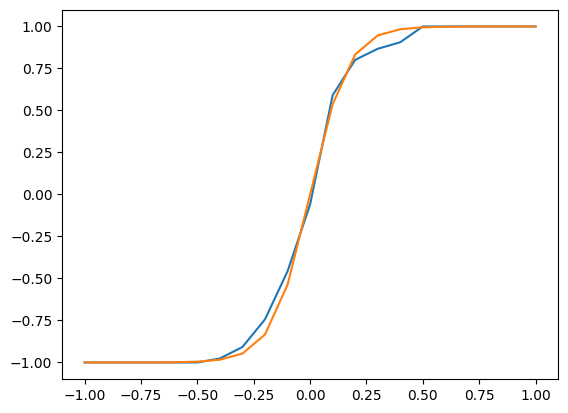

In [253]:
b2s1 = Binary2StochasticBipolar(lfsr_seed=main_seed1, lfsr_taps=main_taps, size=8)
# b2s2 = Binary2StochasticUnipolar(lfsr_seed=main_seed2, lfsr_taps=main_taps, size=8)
# b2s3 = Binary2StochasticUnipolar(lfsr_seed=main_seed3, lfsr_taps=main_taps, size=8)
# mul = MultiplicatorUnipolar(input_modules=[b2s1, b2s2])
# add = TreeAdder(input_modules=[b2s1, b2s2, b2s3])
tanh = STanH(input_modules=[b2s1], size=16)
s2b = Stochastic2BinaryBipolar(input_modules=[tanh])

input_values = [-1 + 0.1 * i for i in range(21)]
output_value = []
for input_value in input_values:
    s2b.reset_clock()
    b2s1.set_input_value(input_value)

    # inputs = [0.3, 0.5, 0.8]
    # weigths = [0.5, 0.3, 0.7]
    # neuron = Neuron(
    #     3,
    #     [[main_seed1, main_seed2, main_seed3], [main_seed4, main_seed5, main_seed6]],
    #     main_taps,
    # )
    # neuron.set_inputs(inputs)
    # neuron.set_weights(weigths)

    output_len = 4096
    for _ in range(output_len):
        s2b.step()
        # print(tanh.input_bits[0])
    output_value.append(s2b.result)

plt.plot(
    input_values,
    output_value,
)
plt.plot(
    input_values,
    [float(np.tanh(6 * input_values[i])) for i in range(len(input_values))],
)
print(float(np.tanh(4 * input_value)))

In [206]:
float(np.tanh(4 * 0.5))

0.9640275800758169